In [1]:
import torch
import matplotlib.pyplot as plt
import math

from renderer import project_gaussians, rasterize_gaussians, get_bounding_boxes
from utils import ellipse_ndim

from matplotlib.patches import Polygon

import numpy as np

### Data

In [2]:
N = 10

mu = (torch.rand((N,3)) - 0.5) * 4.
scale = torch.rand((N,3)) * 0.2
quat = torch.rand((N, 4))
col = torch.rand((N, 3))
opc = torch.rand((N,))

### Projection

In [3]:
# Output Image Width and Height
W = 1920
H = 1072 

In [4]:
fov_x = math.pi / 2.0 # Angle of the camera frustum 90°
focal = 0.5 * float(W) / math.tan(0.5 * fov_x) # Distance to Image Plane

viewmat = torch.eye(4)
viewmat[:3,3] = torch.tensor([0,0,-4])

In [5]:
(
    mu_,
    cov_,
    z
) = project_gaussians(
    means3d=mu,
    scales=scale,
    quats=quat,
    viewmat=viewmat,
    fx=focal,
    fy=focal,
    cx=W/2,
    cy=H/2,
    img_height=H,
    img_width=W
)

(0.0, 1072.0)

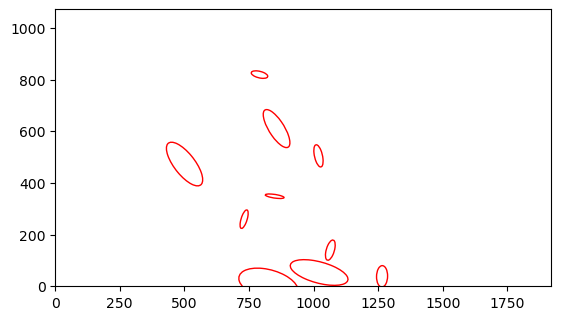

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ellipse_ndim(mu_, cov_, ax, edgecolor='red')

ax.set_aspect('equal', adjustable='box')
ax.set_xlim([0,W])
ax.set_ylim([0,H])

### Rendering

In [7]:
out_img = rasterize_gaussians(
    xys=mu_,
    depths=z,
    covs=cov_,
    conics=None,
    num_tiles_hit=None,
    colors=col,
    opacity=opc,
    img_height=H,
    img_width=W,
    block_width=None,
    background=None,
    return_alpha=None
)

100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


(0.0, 1072.0)

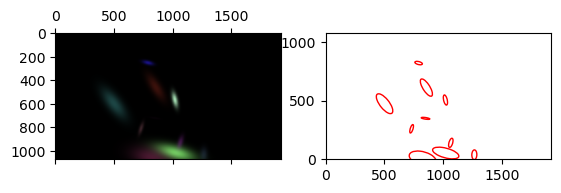

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

### Tiling (SAT)

In [9]:
rot_box = get_bounding_boxes(mu_, cov_)

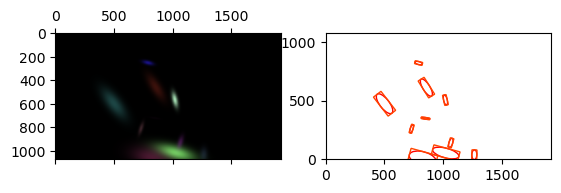

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

for box in rot_box:
 ax2.add_patch(Polygon(box, fc='none', ec='orangered'))

### Tiling

In [11]:
W, H

(1920, 1072)

In [12]:
def plot_tile_map(tile_map, ax=None):
    tH, tW = len(tile_map), len(tile_map[0]) 
    mask = torch.zeros((tH, tW))
    for y in range(tH):
        for x in range(tW):
            if tile_map[y][x]:
                mask[y,x] = sum(tile_map[y][x]) + 1

    mask = torch.nn.functional.interpolate(mask.view(1,1,*mask.shape), size=(H, W)).squeeze()

    if not ax:
        plt.imshow(mask)
    else:
        ax.imshow(mask)

In [13]:
tile_size = 16

In [14]:
tile_map = [[[] for tw in range(W//tile_size)] for th in range(H//tile_size)]

In [15]:
minmax = torch.cat(((rot_box.amin(dim=1) / tile_size).floor()[:,:,None], (rot_box.amax(dim=1) / tile_size).ceil()[:,:,None]), dim=2)

In [16]:
minmax.shape # N, (X,Y), (Min,Max)

torch.Size([10, 2, 2])

In [17]:
minmax[:,0].clamp_(0, W//tile_size - 1)
minmax[:,1].clamp_(0, H//tile_size - 1);

In [18]:
for i, g in enumerate(minmax.to(torch.long)):
    x_min, x_max = g[0]
    y_min, y_max = g[1]

    for x in range(x_min, x_max+1):
        for y in range(y_min, y_max+1):
            tile_map[y][x].append(i)

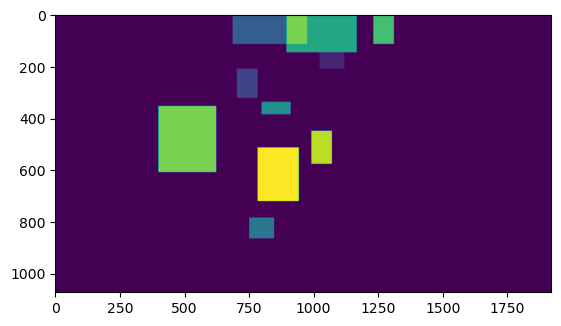

In [19]:
plot_tile_map(tile_map)

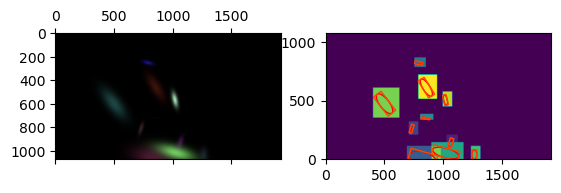

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

plot_tile_map(tile_map, ax=ax2)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

for box in rot_box:
    ax2.add_patch(Polygon(box, fc='none', ec='orangered'))